In [2]:
%run config_check.py

You are currently using this configuration -
Python:  3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
Numpy:  1.14.0
Scipy:  1.0.0
Matplotlib:  2.1.2
Pystan:  2.17.1.0

The code was tested on Python:  3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) [GCC 7.2.0], Numpy:  1.14.0, Scipy:  1.0.0, Matplotlib:  2.1.2, Pystan:  2.17.1.0


In [3]:
# <api>
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the previous parts
from jupyter_cms.loader import load_notebook
smpl1 = load_notebook('./Sampling_part1.ipynb')
smpl2 = load_notebook('./Sampling_part2.ipynb')

# Sampling methods

## Markov chain Monte-Carlo (MCMC)

The previous sampling methods produced independent samples from the target distribution. Markov Chain Monte Carlo (MCMC) methods instead produce a sequence of dependent samples which nevertheless has a desired marginal distribution.

A sequence of random variable $X_1, X_2, \ldots$ is called a Markov chain if their joint density can be factorized as follows:
$$ p(x_1, x_2, \ldots) = p(x_1) \prod_{i=1}^{\infty} p(x_{i+1} | x_1, \ldots, x_{i}) = p(x_1) \prod_{i=1}^{\infty} p(x_{i+1} | x_i) $$
Thus, each variable is independent of its history given its direct predecessor. A Markov chain is called **_homogeneous_** if its transition density $p(x_{i+1}|x_i)$ is the same for all $i \in \mathbb{N}$.

### Detailed Balance

MCMC constructs a Markov chain with a desired stationary distribution $p(x)$. The stationary distribution $p^*(x)$ of a homogeneous Markov chain with transition density $p(x' | x)$ has the property that
$$ p^*(x') = \int p(x' | x) p^*(x) dx, $$
i.e. the distribution is unchanged by the action of the Markov chain.

A sufficient condition to ensure that $p(x)$ is invariant is that the transition probability satisfies **_detailed balance_**:
$$ p^*(x) p(x' | x) = p^*(x') p(x | x') $$
Note that this is not tautological as it requires that $p^*$ is the same on both sides.

Then,
$$ \int p(x' | x) p^*(x) dx = \int p^*(x') p(x | x') dx = p^*(x') \int p(x | x') dx = p^*(x') $$
A Markov chain which satisfies detailed balance is **_reversible_**.

Ideally, we want that the chain converges to its target distribution $p^*(x)$ independent of where it started. This is ensured by the following technical conditions:

* **Ergodic**: A Markov chain is called *ergodic* if every state $x'$ can be reached from any other state $x$, i.e. $\forall x,x' \; \exists n \mbox{ s.t. } p(X_n = x' | X_1 = x) > 0$

  This condition is also called *irreducibility* and implies the existence of a unique invariant measure $p^*(x)$. Further, from the ergodic theorem we get the important property that time averages converge to ensemble averages, i.e.
  $$ \frac{1}{T} \sum_{i=1}^T f(x_i) \underset{T \to \infty}{\longrightarrow} \mathbb[E]_{p^*}[f]  $$

* **Aperiodic**: A Markov chain is called *aperiodic* if the period of all its state is 1. The period of state $x$ is defined as
$$ k = \mathtt{gcd}\{n > 1: p(X_n = x | X_1 = x) > 0\} $$
where $\mathtt{gcd}$ is the greatest common divisor. Thus, in an aperiodic chain each state can be revisited at irregular intervals.

When the Markov chain is irreducible and aperiodic it is called *mixing* and it converges to its invariant distribution from any starting distribution. In practice it is usually easy to construct construct a mixing chain, e.g. by chosing a transition density which has full support, but the mixing time can be very long.

### Metropolis-Hastings

The Metropolis-Hastings algorithm draws a new sample from $p(x)$ starting from a sample $x$ as follows:

* Draw $x'$ from a proposal distribution $q(x'|x)$
* With probability $$a_{x,x'} = \min\{1, \frac{p(x') q(x|x')}{p(x) q(x'|x)}\}$$ accept $x'$ as the new sample. Otherwise stay at $x$ and return it as the new sample.

**Exercise:** Show that this Markov chain satisfies detailed balance with respect to $p(x)$

Note that the acceptance condition simplifies when the proposal distribution is symmetric, i.e. $q(x'|x) = q(x|x')$. In this case, the algorithm is also known as the _Metropolis algorithm_ with the intuitve acceptance probability $\min\{1, \frac{p(x')}{p(x)}\}$.

The algorithm also works if the normalization constant of $p(x)$ is unavailable as it cancels in the acceptance condition.

In [2]:
# <api>
class Proposer (object):
    """
    Wraps two functions needed by a proposer q, i.e.
      Draw a new value y ~ q.propose(x)
      Compute log transition probability q.log_trans_prob(x,y) 
    """
    def __init__(self, propose, log_trans_prob):
        self.propose = propose
        self.log_trans_prob = log_trans_prob
        
    def propose(self, x):
        return self.propose(x)
    
    def log_trans_prob(self, x, y):
        return self.log_trans_prob(x, y)

class MetropolisHastings (smpl1.Sampling):
    def __init__(self, log_p, q, x):
        """
        q is assumed to be a proposer and log_p computes log p(x)
        """
        self.x = x # Current sample
        self.log_p = log_p
        self.q = q
        self.num_samples = 0
        self.accepted = 0
        
        
    def __str__ (self):
        return "Metropolis Hastings: Accepted %d out of %d samples" % (self.accepted, self.num_samples)
        
    def sample (self):
        self.num_samples += 1
        # Propose new candidate
        x_prime = self.q.propose(self.x)
        a = self.log_p(x_prime) + self.q.log_trans_prob(x_prime, self.x) \
            - self.log_p(self.x) - self.q.log_trans_prob(self.x, x_prime)
        u = np.random.uniform()
        if np.log(u) < a:
            self.accepted += 1
            self.x = x_prime
        return self.x    
    
    
    def reset_counters(self):
        self.num_samples = 0
        self.accepted = 0

NameError: name 'smpl1' is not defined

In [5]:
sampling = MetropolisHastings(log_p=lambda x: np.log(smpl2.p(x)), 
                              q=Proposer(lambda x: norm(loc=x, scale=0.5).rvs(),
                                         lambda x, y: norm(loc=x, scale=0.5).logpdf(y)),
                              x=-3.0)

smpl1.show_sampling(sampling, plotter=smpl1.gauss_hist, N=2500)
print(sampling)

HBox(children=(Button(description='Redraw', style=ButtonStyle()), IntSlider(value=7, continuous_update=False, description='Bins:', max=30, min=1), IntSlider(value=100, continuous_update=False, description='Samples:', max=2500, min=10, step=10)))

Output()

Metropolis Hastings: Accepted 2120 out of 2500 samples


Using again the more difficult 2-dimensional example, we can illustrate how the sampler moves around the target density:

Metropolis Hastings: Accepted 7 out of 1000 samples


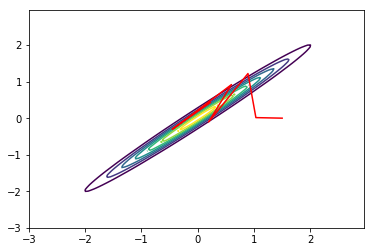

In [6]:
sampling = MetropolisHastings(log_p=smpl2.p2d.logpdf, \
                              q=Proposer(lambda x: multivariate_normal(mean=x, cov=1e2*np.eye(2)).rvs(),
                                         lambda x,y: 0), # Proposal is symmetric
                              x=[1.5,0])
samples = [sampling.sample() for _ in range(1000)]
samples

plt.plot(np.array(samples)[:,0], np.array(samples)[:,1], 'r-')
plt.contour(smpl2.X, smpl2.Y, smpl2.p2d.pdf(smpl2.XY))
print(sampling)

This example also illustrates the importance of choosing a suitable proposal distribution $q(x'|x)$. If $q$ is tightly concentrated almost all proposals are accepted, but the chain moves very slowly. Contrary, if $q$ is very broad the acceptance rate is low since most proposals fall into regions of low probability and the chain moves again slowly. In both cases, the mixing time of the chain is very long and we would need many samples to estimate reliable averages.

In [7]:
# <api>
def mixing_demo (q_var):
    n = len(q_var)
    for i in range(n):
        q = Proposer(lambda x: multivariate_normal(mean=x, cov=np.sqrt(q_var[i])*np.eye(2)).rvs(),
                     lambda x,y: 0) # Proposal is symmetric
        sampling = MetropolisHastings(log_p=smpl2.p2d.logpdf, q=q, x=[1.5,0])
        samples = [sampling.sample() for _ in range(1000)]
        plt.subplot(1,n,i+1)
        plt.title('Sdev[q] = ' + str(np.sqrt(q_var[i])))
        plt.plot(np.array(samples)[:,0], 'b-')

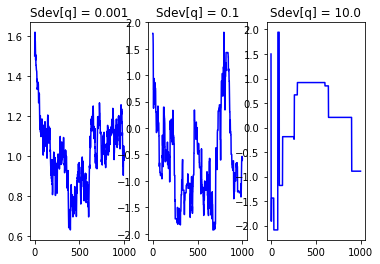

In [8]:
mixing_demo(np.array([0.001, 0.1, 10])**2)

Is there an optimal proposal or acceptance rate?

* Obviously, choosing $q(x'|x) = p(x')$ would be optimal as it is always accepted and produces independent samples ...
* When the proposal is a circular Gaussian an optimal acceptance rate of 0.234 has been derived.

As a rule of thumb, the acceptance rate is often adjusted to around 0.2. But as an information theoretic argument by MacKay suggests, Metropolis-Hastings sampling is always rather inefficient as it takes a random walk across the space. In general, when the probable states of $p(x)$ cover a length scale of $L$ and the proposal takes steps of size $\epsilon$, we need at least $(\frac{L}{\epsilon})^2$ steps to obtain an (almost) independent sample. This is based on the observation that a random walk/diffusion with step size/standard deviation $\epsilon$ covers a distance of about $\sqrt{T} \epsilon$ after $T$ steps.

Thus, many algorithms try to utilize proposals adjusted to the target distribution in order to improve mixing, speeding up sampling.

**Exercise:** Illustrate the effect of the proposal width when sampling from a multi-modal target distribution.

### Convergence diagnostics

Most MCMC algorithms, e.g. Metropolis-Hastings, produce a Markov chain sampling from the desired target distribution. Thus, all samples produced are correct in principal, but the intial samples can depend strongly on the initialization especially if the chain mixes slowly. It is common practice to drop an initial part of the samples, the so called *burn-in* period.

In general, it would be desirable to have diagnostic tools in order to access the quality of samples produced and detect sampling problems. In particular, one wants to know how well the chain mixes and how many (almost) inpedendent have been produced. In the literature, several diagnostics have been proposed ... here, some of them are listed:

* Traceplot: Always look at your samples as problems often show up visually (see mixing example above)
* Autocorrelation: Similar to importance sampling an estimate of the effective sample size can be computed. In the case of MCMC, the sample size is reduced as the samples are dependent and thus empirical averages are less reliable when taken over dependent samples. A commonly used measure of effective sample size is defined as follows:
$$ N_{eff} = \frac{N}{1 + 2 \sum_{\tau=1}^{\infty} \rho_{\tau}}$$
where $\rho_{\tau}$ denotes the correlation coefficient at lag $\tau$.

  This is motivated from the sample mean of a stationary process $X_1, X_2, \ldots$. Then, the sample mean $\hat{\mu}_N = \frac{1}{N} \sum_{i=1}^N X_i$ has mean $$\mathbb{E}[\hat{\mu}_N] = \mathbb{E[X]}$$ and variance $$\mathbb{V}ar[\hat{\mu}_N] = \frac{1}{N} \sum_{\tau=-N}^N (1 - \frac{|\tau|}{N}) \gamma_{\tau}$$ where $\gamma_{\tau} = \mathbb{C}ov[X_t, X_{t+\tau}]$.
  
  Now, when $\sum_{\tau} |\gamma_{\tau}| < \infty$, we see that the variance converges as 
  $$N \mathbb{V}ar \to_{\infty} \sum_{\tau = -\infty}^{\infty} \gamma_{\tau} = \sigma^2 \sum_{\tau = -\infty}^{\infty} \rho_{\tau}$$
  and compared to the case of independent samples the variance is increased by a factor of $1 + 2 \sum_{\tau=1}^{\infty} \rho_{\tau}$.
  
  In practice, the autocorrelation function has to be estimated which is often done by fitting an AR(1) model to the produced samples. Obviously, plotting the autocorrelation function is also useful to access the quality of MCMC samples.
* Convergence: To diagnose convergence, i.e. check if all samples can be considered as being drawn from the same distribution, the following two methods are commonly used:
    * Geweke proposed to compare the mean of two non-overlapping parts of the produced samples, e.g. the first 10% compared to the last 50%. Convergence is then diagnosed if a t-test cannot reject that the two means are the same.
    * Gelman and Rubin proposed a more sophisticated method which assumes that $m$ MCMC-chains have been simulated. Then, they define the *scale reduction factor*
$$ \hat{R} = \sqrt{\frac{\hat{\sigma}^2}{W}} $$
This is based on the observation that the variance can be estimated in two ways: As the mean of the variances within each chain, $W$ or as the variance of all samples $\hat{\sigma}^2$. When the chain has not converged $W$ tends to underestimate the true variance as not all of the sampling space has been explored, while $\hat{\sigma}^2$ tends to overstate the variance if the initial conditions are chosen at arbitrary, over-dispersed positions. Thus, convergence is detected by $\hat{R}$ being close to one.